<a href="https://colab.research.google.com/github/HereBeCode/StanceDetectionML-Brockport/blob/main/MultiClass_YT_Comment_Sentiment_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import glob
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
print(tf.__version__)

2.8.2


# Import Dataset
We can use the text_dataset_from_directory utility which expects a specific directory structure. Import your dataset as a zipped folder with the following structure:


    main_directory/
      ...class_a/
        ...a_text_1.txt
        ...a_text_2.txt
      ...class_b/
        ...b_text_1.txt
        ...b_text_2.txt


The zipped folder can be unzipped as follows:



In [ ]:
!unzip "/content/AbortionData.zip" -d "/content"

Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. tf.data is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.


In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/AbortionData/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 1921 files belonging to 3 classes.
Using 1537 files for training.



As you can see above, of the samples available in the training folder, you will use 80% for training. As you will see in a moment, you can train a model by passing a dataset directly to model.fit. If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Comment", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Comment b'i dont understand how people can justify using their personal beliefs to take away the rights of others  i think the exact same thats why they are your own personal beliefs they are just meant for you  not for you to push on other people'
Label 2
Comment b'abortion is obviously  murder pray roe is overturned  '
Label 0
Comment b'why are we trying to control women its her body its her choice like abby had a choice to eat a couple of cheeseburgers or a small salad its obvious what she chose but im not going  stop her cause its none of my business '
Label 2


Notice the reviews contain raw text (with punctuation and occasional HTML tags like <br/>). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the class_names property on the dataset.


In [ ]:
print("Label 0 corresponds to: ", raw_train_ds.class_names[0])
print("Label 1 corresponds to: ", raw_train_ds.class_names[1])

Label 0 corresponds to:  neg
Label 1 corresponds to:  neu


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/AbortionData/train',
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 1921 files belonging to 3 classes.
Using 384 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/AbortionData/test',
    batch_size=batch_size
)

Found 481 files belonging to 3 classes.


# Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization layer can be included directly inside your model, as shown later in this tutorial.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br /', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.


In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).


In [ ]:
#Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'human zigot human fetus human unborn baby human born baby human infant human child human teen human adult its all the same human', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  65, 2611,   65,  127,   65,  125,   30,   65,  111,   30,   65,
        1180,   65,   36,   65, 1110,   65,  855,   24,   44,    2,  174,
          65,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1238])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  begin
 313 --->  shes
Vocabulary size: 5288


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [ ]:
print(vectorize_layer.get_vocabulary())

['', '[UNK]', 'the', 'to', 'a', 'and', 'is', 'of', 'you', 'that', 'i', 'it', 'have', 'for', 'are', 'abortion', 'not', 'they', 'in', 'be', 'life', 'if', 'but', 'people', 'its', 'dont', 'or', 'this', 'with', 'their', 'baby', 'your', 'an', 'what', 'choice', 'so', 'child', 'who', 'do', 'should', 'as', 'women', 'pro', 'on', 'all', 'no', 'just', 'want', 'about', 'my', 'right', 'we', 'can', 'because', 'will', 'she', 'her', 'at', 'these', 'like', 'think', 'how', 'them', 'woman', 'there', 'human', 'was', 'when', 'get', 'one', 'body', 'has', 'babies', 'would', 'abortions', 'murder', 'up', 'im', 'being', 'from', 'then', 'god', 'why', 'children', 'out', 'more', 'only', 'cant', 'care', 'own', 'me', 'know', 'even', 'by', 'sex', 'make', 'prolife', 'many', 'pregnant', 'mother', 'say', 'killing', 'support', 'had', 'birth', 'those', 'take', 'need', 'were', 'other', 'believe', 'born', 'any', 'doesnt', 'wrong', 'having', 'also', 'than', 'someone', 'prochoice', 'live', 'am', 'stop', 'our', 'way', 'unborn',

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Create the model
It's time to create your neural network:

In [ ]:
VOCAB_SIZE = len(vectorize_layer.get_vocabulary())
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(VOCAB_SIZE, 32),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),#, return_sequences=True)),
                             #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                             tf.keras.layers.Dense(128, activation='relu'),
                             #tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64, activation='relu'),
                             #tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation='relu'),
                            # tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(3)
])

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 32)          169216    
                                                                 
 bidirectional_17 (Bidirecti  (None, 64)               16640     
 onal)                                                           
                                                                 
 dense_35 (Dense)            (None, 128)               8320      
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 3)                 99        
                                                     

In [ ]:
# embedding_dim = 16

# model = tf.keras.Sequential([
#                              layers.Embedding(len(vectorize_layer.get_vocabulary()), embedding_dim),
#                              layers.Dense(256),
#                              layers.Dense(128),
#                              layers.Dense(32),
#                              layers.Dropout(0.2),
#                              layers.GlobalAveragePooling1D(),
#                              layers.Dropout(0.2),
#                              layers.Dense(3)])
# model.summary()

The layers are stacked sequentially to build the classifier:


1.   The first layer is an Embedding layer. 
This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial. 
2.   Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3.   This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
4.   The last layer is densely connected with a single output node.



# Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function:




In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
You will train the model by passing the dataset object to the fit method.

In [ ]:
epochs = 4
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/4
49/49 [==============================] - 14s 207ms/step - loss: 0.9842 - accuracy: 0.5420 - val_loss: 0.9336 - val_accuracy: 0.5052
Epoch 2/4
49/49 [==============================] - 9s 187ms/step - loss: 0.8610 - accuracy: 0.5621 - val_loss: 0.8713 - val_accuracy: 0.5677
Epoch 3/4
49/49 [==============================] - 9s 189ms/step - loss: 0.6608 - accuracy: 0.7105 - val_loss: 0.7292 - val_accuracy: 0.6927
Epoch 4/4
49/49 [==============================] - 9s 185ms/step - loss: 0.4068 - accuracy: 0.8295 - val_loss: 0.7659 - val_accuracy: 0.7161


# Evaluate the model
Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

16/16 [==============================] - 1s 43ms/step - loss: 0.7928 - accuracy: 0.7297
Loss:  0.7928338646888733
Accuracy:  0.7297297120094299


# Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

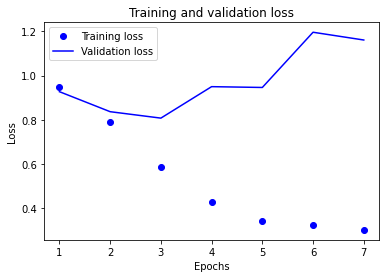

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo' is for 'blue dot'
plt.plot(epochs, loss, 'bo', label="Training loss")
# b is for 'solid blue line'
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

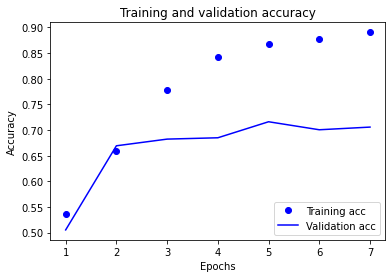

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the tf.keras.callbacks.EarlyStopping callback.


# Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

16/16 [==============================] - 6s 106ms/step - loss: 1.1976 - accuracy: 0.7401
0.7401247620582581


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.


In [ ]:
#shutil.rmtree('./AbortionData')